In [1]:
# _____ ______  _____        _     _____ _   _ _____ 
#|  __ \| ___ \|  _  |      | |   |_   _| | | |  ___|
#| |  \/| |_/ /| | | |______| |     | | | | | | |__  
#| | __ | ___ \| | | |______| |     | | | | | |  __| 
#| |_\ \| |_/ /\ \_/ /      | |_____| |_\ \_/ / |___ 
# \____/\____/  \___/       \_____/\___/ \___/\____/ 
                                                    
## 20210823 - This is a script that will be used for LIVE data updates/plots at GBO during testing
## We will begin by importing the proper packages from the Drone Modules:
from dronehacks.GBO_Corr_Class import *
from dronehacks.Drone_Class import *

In [2]:
## Let's specify the DISH COORDINATES from Pranav's Email:
    # 1. Want to initialize with additional receiver/array variables in dimensioned arrays:
            ##############################################################################################
            # I  Variable      # Dimension # description
            ##############################################################################################
            # A. Keys          # n dishes  # (string with name or channel index?)
            # B. Coordinates   # n by 3vec # (Vector position in local cartesian (E,N,U) relative origin)
            # C. Pointings     # n by 3vec # (Unit Vector in local cartesian (E,N,U))
            # D. Polarizations # n by 3vec # (Unit Vector in local cartesian (E,N,U))
            ##############################################################################################
    # 2. Want to calculate drone coordinates on per-dish basis, for xyz and rpt from origin based arrays

## Key, Position, Channel, Polarization, Pointing Variable Notes:

## 8 Dish 16Channel Array Configuration for the 6m Array at GBO:
# Dish 0:  [0, 1], (0.0, 0.0, 0.0)
# Dish 7:  [3, 2], (-24.215395745765452, -12.605737141316427, 0.0)
# Dish 2:  [4, 5], (-8.403824760877617, 16.143597163843634, 0.0)
# Dish 3:  [7, 6], (-8.071798581921817, -4.2019123804388085, 0.0)
# Dish 4:  [9, 8], (-12.273710962360624, 3.869886201483008, 0.0)
# Dish 5:  [10, 11], (-16.475623342799434, 11.941684783404824, 0.0))
# Dish 6:  [12, 13], (-20.345509544282443, -0.33202617895580033, 0.0) # CHIME FEED
# Dish 8:  [14, 15], (-28.41730812620426, -4.53393855939461, 0.0)

## 4Dish 8Channel Array Configuration for the 6m Array at GBO:
# Dish 0:  [0, 1], (0.0, 0.0, 0.0)
# Dish 7:  [3, 2], (-24.215395745765452, -12.605737141316427, 0.0)
# Dish 2:  [4, 5], (-8.403824760877617, 16.143597163843634, 0.0)
# Dish 3:  [7, 6], (-8.071798581921817, -4.2019123804388085, 0.0)

## Key, Position, Channel, Polarization, Pointing Variable Assignment:
## RECEIVER INFORMATION is needed to initialize the geometric environments: ##
## Must include some 'key' strings for labelling/identifying receivers: [Pranav's Conventions]
Array_Keys=["Dish_0","Dish_7","Dish_2","Dish_3","Dish_4","Dish_5","Dish_6","Dish_8"]
## Specify Coordinate Origin: #810m about MSL
GBO_HIRAX_DISH_0=pygeodesy.ellipsoidalNvector.LatLon(38.429280, -79.844990, 810).to3llh()
## Must Specify Coordinates and Pointings of receivers in Local Cartesian in an array of shape: n_receivers x 3 ##
Array_Coords=np.array([[0.0, 0.0, 0.0], # "Dish_0" \
                       [-24.215395745765452, -12.605737141316427, 0.0], # "Dish_7" \
                       [-8.403824760877617, 16.143597163843634, 0.0], # "Dish_2" \
                       [-8.071798581921817, -4.2019123804388085, 0.0], # "Dish_3" \
                       [-12.273710962360624, 3.869886201483008, 0.0], # "Dish_4" \
                       [-16.475623342799434, 11.941684783404824, 0.0], # "Dish_5" \
                       [-20.345509544282443, -0.33202617895580033, 0.0], # "Dish_6" \
                       [-28.41730812620426, -4.53393855939461, 0.0]]) # "Dish_8" \
## If pointings are defined by vectors in Local Coordinates (E,N,U) use:
Array_Pointings=np.array([[0,0,1], # +Z (up) in LC \
                          [0,0,1],\
                          [0,0,1],\
                          [0,0,1],\
                          [0,0,1],\
                          [0,0,1],\
                          [0,0,1],\
                          [0,0,1]])
## If pointings are defined by angles from zenith, use:
Array_Pointings=np.array([RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),  # e.g. 1 deg of yaw and roll \
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0])])
## Define Array Polarizations (2 per dish) in Local Cartesian E,N,U:
Array_Pols=np.array([[[1,0,0],[0,1,0]], # E,N \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]]])

## 2 DISH PLOTTING:
GBO2_chmap=[0,1]
GBO2_automap=np.array([0,2])
## 4 DISH PLOTTING:
GBO4_chmap=np.array([0,1,3,2,4,5,7,6])
GBO4_automap=np.array([ 0,  8, 21, 15, 26, 30, 35, 33])
## 8 DISH PLOTTING:
GBO8_chmap=np.array([0,1,3,2,4,5,7,6,9,8,10,11,12,13,14,15])
GBO8_automap=np.array([0,  16,  45,  31,  58,  70,  91,  81, 108, 100, 115, 121, 126, 130, 133, 135])
#GBO8_automap=np.zeros(len(GBO8_chmap)).astype(int)
#prodmat=np.array([element for tupl in quicktest.prod for element in tupl]).reshape(len(quicktest.prod),2)
#for i,j in enumerate(GBO8_chmap):
#    GBO8_automap[i]=np.intersect1d(np.where(prodmat[:,0]==j),np.where(prodmat[:,1]==j))

## Information from Pranav's Emails/Sketches that has been used to create the above channelization:   
    
## Pranav's DISH COORDINATES were given in local cartesian, but are they in E,N,U?: YES
## Channel Map:
# Dish 0:  [0, 1],
# Dish 2:  [4, 5],
# Dish 3:  [6, 7],
# Dish 4:  [8, 9],
# Dish 5:  [10, 11],
# Dish 6:  [12, 13],
# Dish 7:  [2, 3],
# Dish 8:  [14, 15]

## Position Map:
# {'0': (0.0, 0.0, 0.0),
#  '1': (0.0, 0.0, 0.0),
# '2': (-24.215395745765452, -12.605737141316427, 0.0),
#  '3': (-24.215395745765452, -12.605737141316427, 0.0),
#  '4': (-8.403824760877617, 16.143597163843634, 0.0),
#  '5': (-8.403824760877617, 16.143597163843634, 0.0),
#  '6': (-8.071798581921817, -4.2019123804388085, 0.0),
#  '7': (-8.071798581921817, -4.2019123804388085, 0.0),
#  '8': (-12.273710962360624, 3.869886201483008, 0.0),
#  '9': (-12.273710962360624, 3.869886201483008, 0.0),
#  '10': (-16.475623342799434, 11.941684783404824, 0.0),
#  '11': (-16.475623342799434, 11.941684783404824, 0.0),
#  '12': (-20.345509544282443, -0.33202617895580033, 0.0),
#  '13': (-20.345509544282443, -0.33202617895580033, 0.0), # Hirax Feed
#   '14': (-28.41730812620426, -4.53393855939461, 0.0),
#  '15': (-28.41730812620426, -4.53393855939461, 0.0)}

## Polarization Map
#p1 = np.array([0, 3, 4, 7, 9, 10, 12, 14])
#p2 = np.array([1, 2, 5, 6, 8, 11, x, 15])

(-20.0, 20.0)

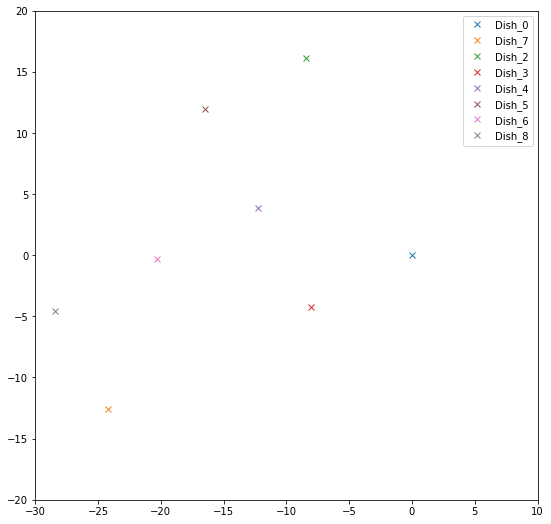

In [3]:
fig,ax1=subplots(nrows=1,ncols=1,figsize=(9,9))

for i,key in enumerate(Array_Keys):
    plot(Array_Coords[i,0],Array_Coords[i,1],'x',label=key)
legend()

ax1.set_xlim(-30,10)
ax1.set_ylim(-20,20)

In [4]:
##Thursday Diagnostics:

## NO RTK ANYWHERE SKY SPECTRA
gaindir='/Users/wct9/Desktop/GBO/20210826T130602Z_yale_drone_yale_digitalgain/'
datadir='/Users/wct9/Desktop/GBO/20210826T130602Z_yale_drone/corr/20210826T130644Z/'
#RTK_away_test=Corr_Data(Data_Directory=datadir,visindex=np.sort(GBO8_automap),Gain_Directory=gaindir)

## RTK ON TEST AT FAR AWAY LOCATION
gaindir='/Users/wct9/Desktop/GBO/20210826T131433Z_yale_drone_yale_digitalgain/'
datadir='/Users/wct9/Desktop/GBO/20210826T131433Z_yale_drone/corr/20210826T131445Z/'
#RTK_on_test=Corr_Data(Data_Directory=datadir,visindex=np.sort(GBO8_automap),Gain_Directory=gaindir)

## PULSED SOURCE SPIN FLIGHT 1:
gaindir='/Users/wct9/Desktop/GBO/20210826T133606Z_yale_drone_yale_digitalgain/'
datadir='/Users/wct9/Desktop/GBO/20210826T133606Z_yale_drone/corr/20210826T133618Z/'
#pulsedspin=Corr_Data(Data_Directory=datadir,visindex=np.sort(GBO8_automap),Gain_Directory=gaindir)

## PULSED GRID FLIGHT 1: SCIENCE QUALITY
gaindir='/Users/wct9/Desktop/GBO/20210826T141003Z_yale_drone_yale_digitalgain/'
datadir='/Users/wct9/Desktop/GBO/20210826T141003Z_yale_drone/corr/20210826T141017Z/'
#PF1=Corr_Data(Data_Directory=datadir,visindex=np.sort(GBO8_automap),Gain_Directory=gaindir)

## PULSED GRID FLIGHT 2: SCIENCE QUALITY
gaindir='/Users/wct9/Desktop/GBO/20210826T143504Z_yale_drone_yale_digitalgain/'
datadir='/Users/wct9/Desktop/GBO/20210826T143504Z_yale_drone/corr/20210826T143516Z/'
#PF2=Corr_Data(Data_Directory=datadir,visindex=np.sort(GBO8_automap),Gain_Directory=gaindir)

## PULSED GRID FLIGHT 3: SCIENCE QUALITY
gaindir='/Users/wct9/Desktop/GBO/20210826T145839Z_yale_drone_yale_digitalgain/'
datadir='/Users/wct9/Desktop/GBO/20210826T145839Z_yale_drone/corr/20210826T145851Z/'
#PF3=Corr_Data(Data_Directory=datadir,visindex=np.sort(GBO8_automap),Gain_Directory=gaindir)

## 200m Pulsed Grid Flight w/ 8 Channels / 4 Dishes:
gaindir='/Users/wct9/Desktop/GBO/20210826T185621Z_yale_drone_yale_digitalgain/'
datadir='/Users/wct9/Desktop/GBO/20210826T185621Z_yale_drone/corr/20210826T185632Z/'
pulsedgrid200m=Corr_Data(n_channels=8,chmap=GBO8_chmap,Data_Directory=datadir,Gain_Directory=gaindir)


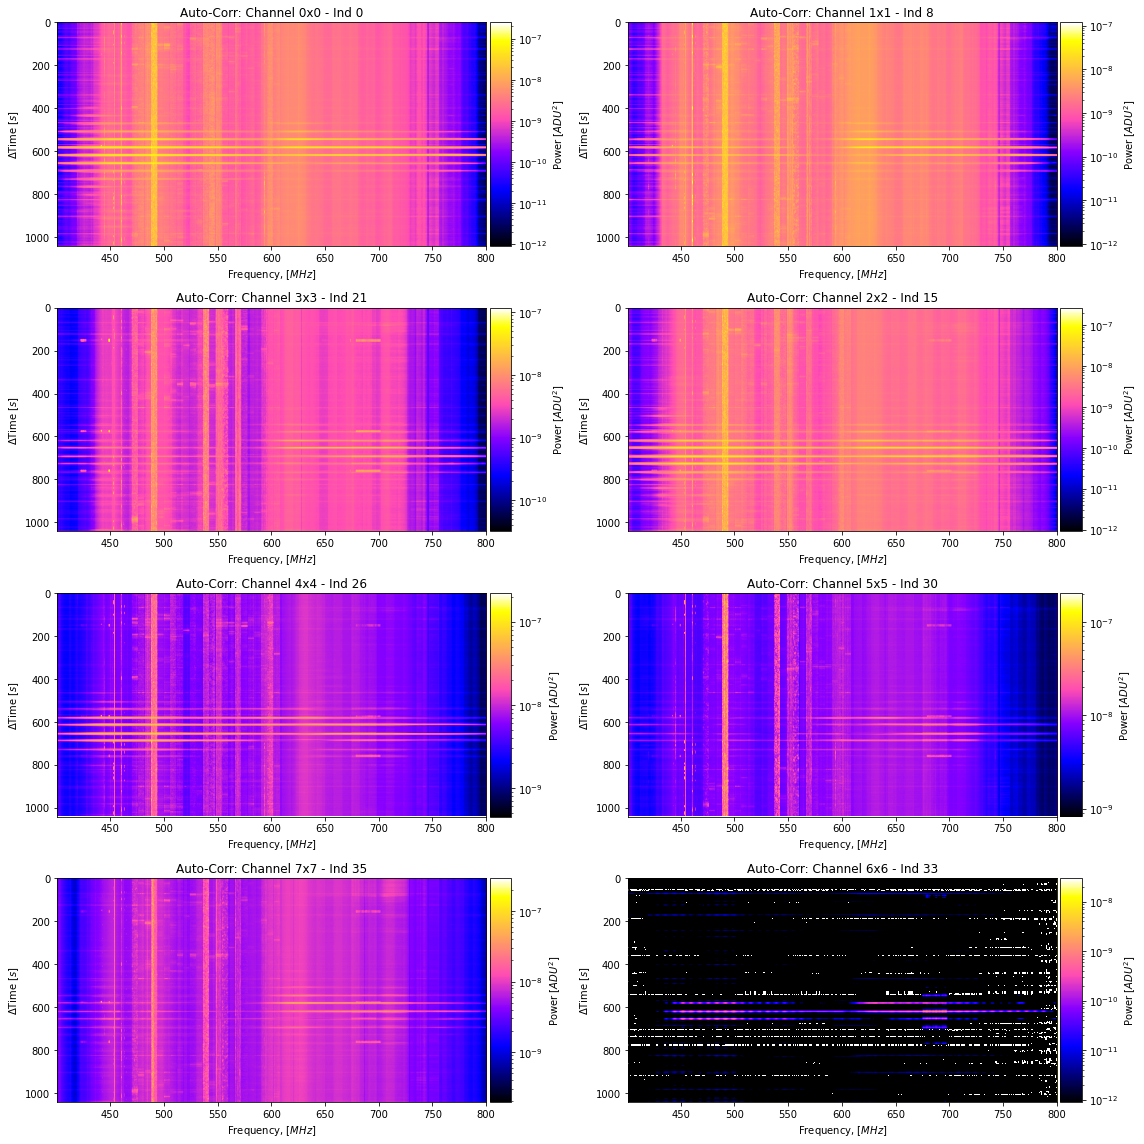

In [5]:
pulsedgrid200m.Plot_Auto_Corr_Waterfalls()

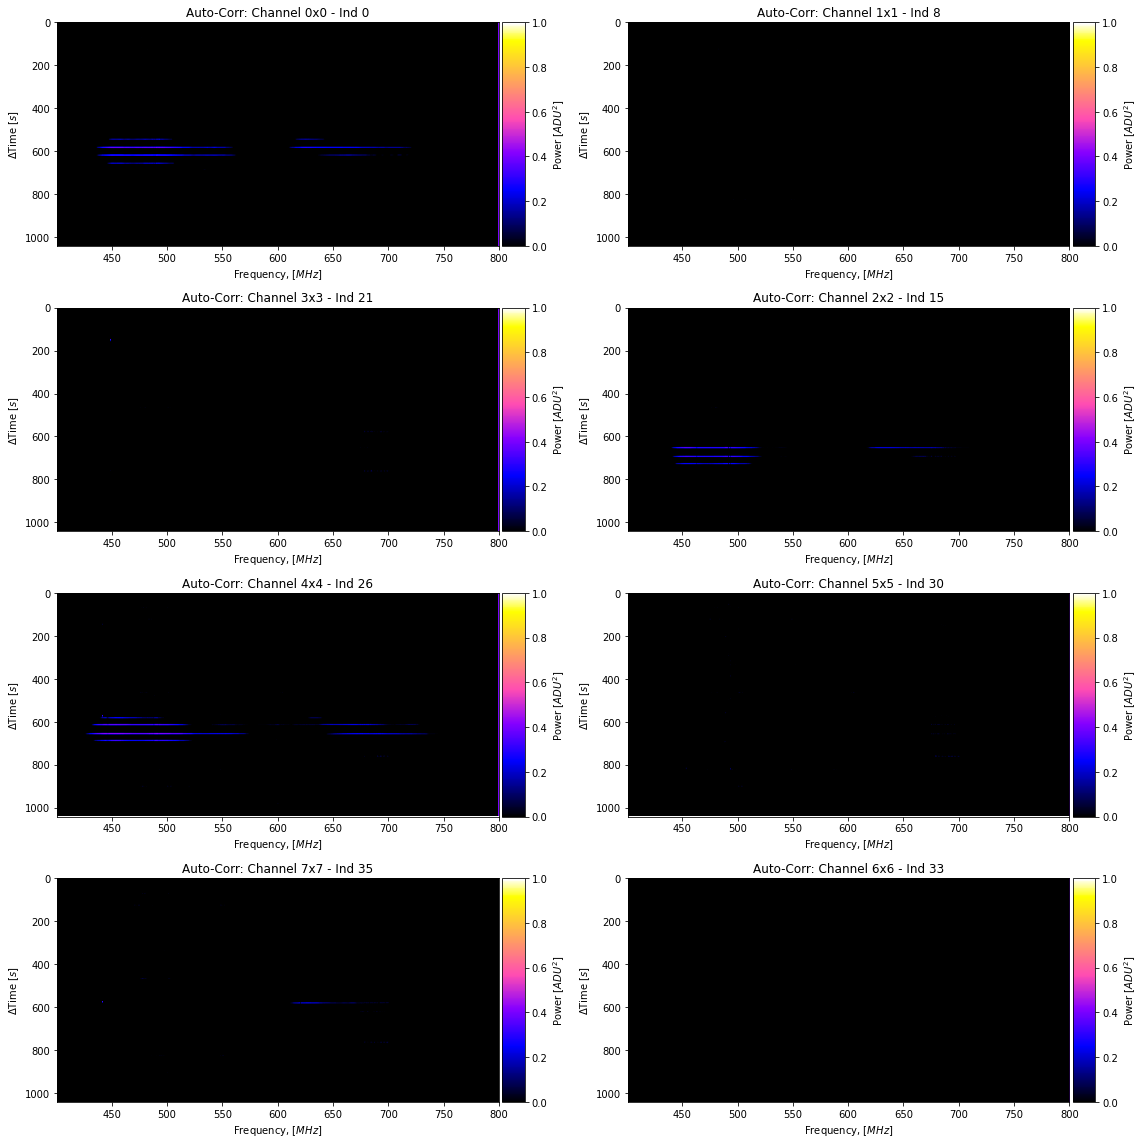

In [6]:
pulsedgrid200m.Plot_Auto_Corr_Saturation_Maps()

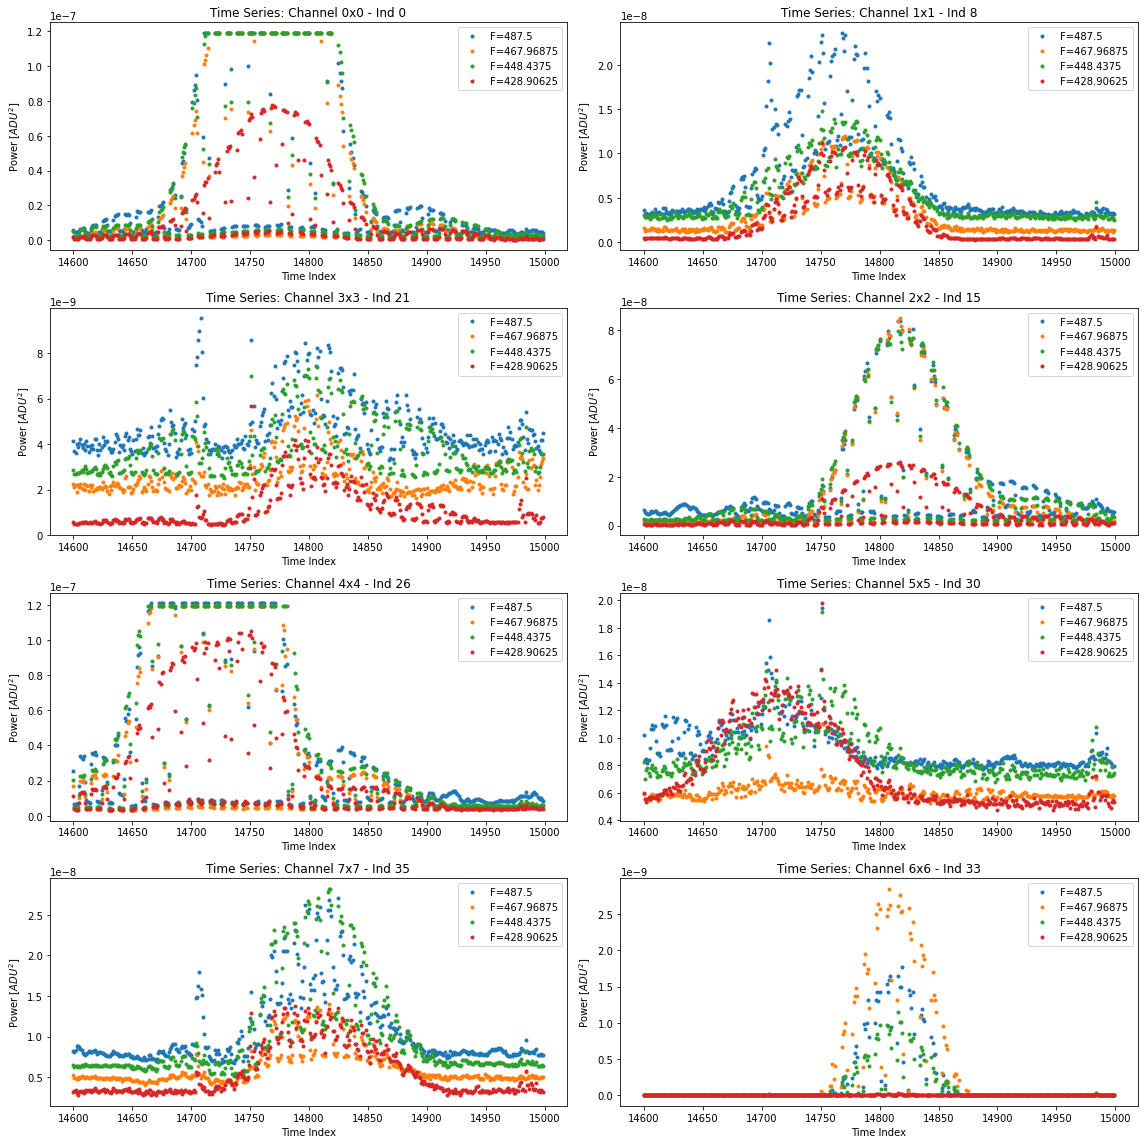

In [28]:
pulsedgrid200m.Plot_Auto_Corr_Time_Series(tbounds=[14600,15000],freqlist=[800,850,900,950])

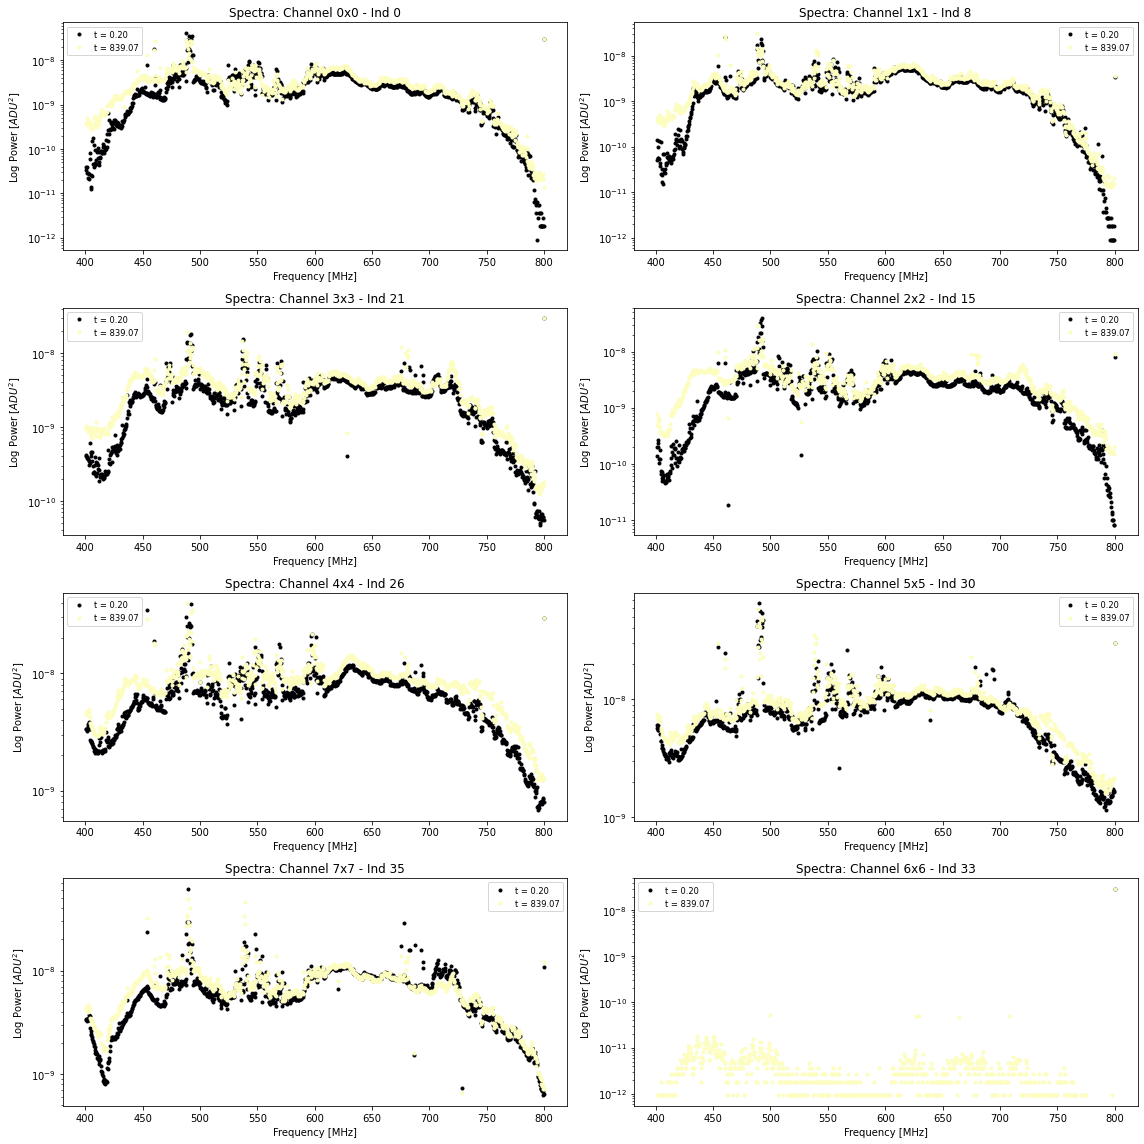

In [8]:
pulsedgrid200m.Plot_Auto_Corr_Spectra(tbounds=[5,-5],tstep=20000)

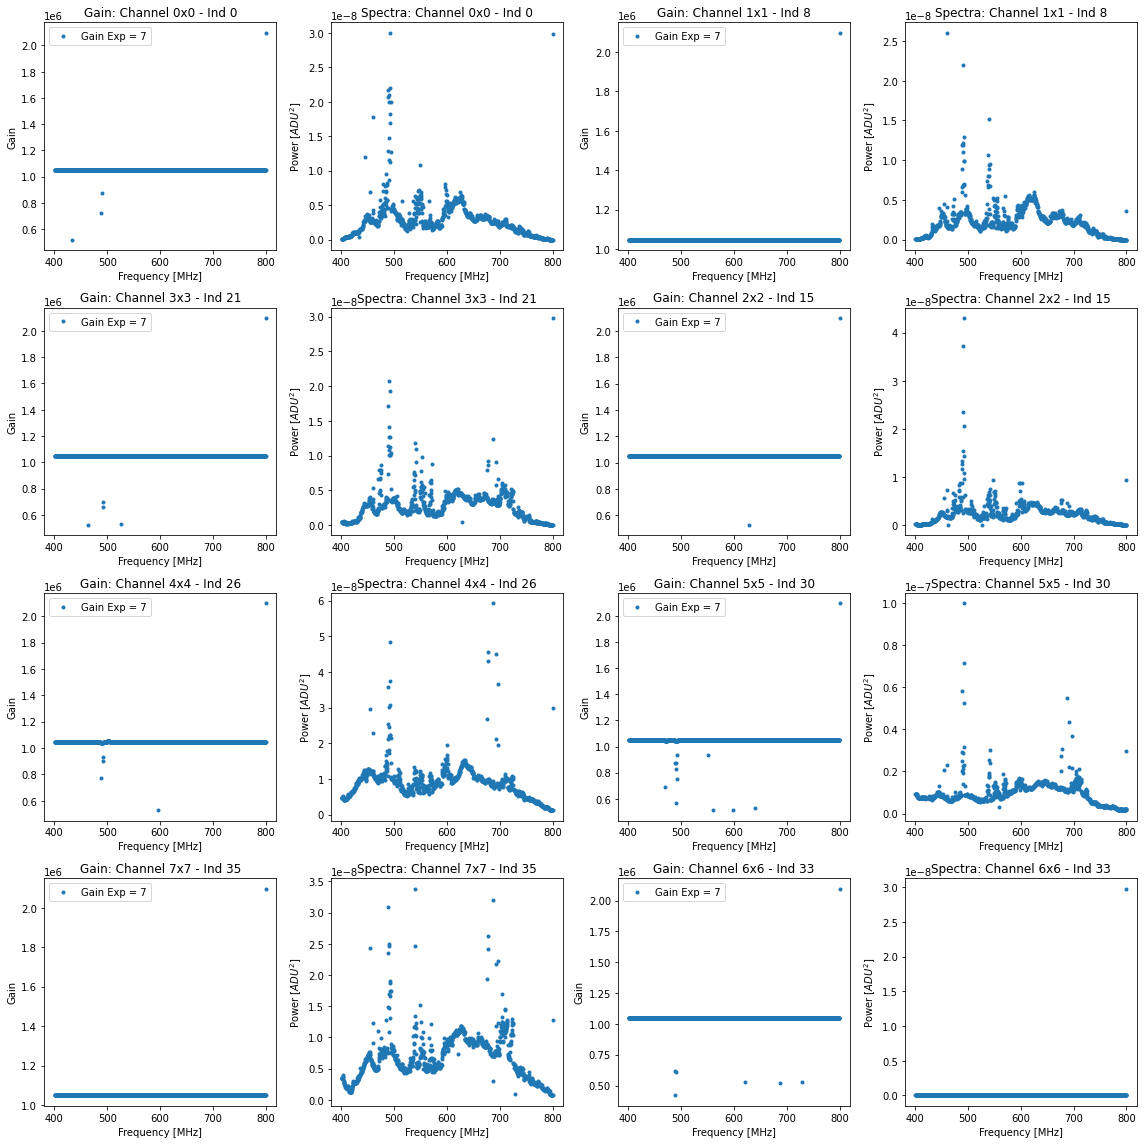

In [16]:
pulsedgrid200m.Plot_Gains_vs_Data(tind=14000)

In [10]:
stop

NameError: name 'stop' is not defined

In [ ]:
print(31*256*0.042)
print((currenttest.t_arr_datetime[-1]-currenttest.t_arr_datetime[0]).total_seconds())


In [ ]:
fd=h5py.File("../Desktop/GBO/20210826T180302Z_yale_drone/raw_acq/000000",'r')

In [ ]:
print(fd['timestamp'][:][0])

In [ ]:
fd['index_map']['time'][:]

In [ ]:
fig,ax1=subplots(nrows=1,ncols=1,figsize=(9,9))
#ax1.plot([(bgtest1.t_arr_datetime[k+1]-bgtest1.t_arr_datetime[k]).total_seconds() for k in range(600)],'.')
ax1.plot(np.diff(fd['index_map']['time'][:]['fpga_count'])*2.56e-6,'.')

In [ ]:
333/1214.14

In [ ]:
fig,ax1=subplots(nrows=1,ncols=1,figsize=(9,9))
ax1.plot([(currenttest.t_arr_datetime[k+1]-currenttest.t_arr_datetime[k]).total_seconds() for k in range(1000)],'.')


In [ ]:
## BACKGROUND INITIALIZATION LEVEL TESTS:
## PULSED GRID FLIGHT 2: SCIENCE QUALITY
gaindir='/Users/wct9/Desktop/GBO/20210826T162023Z_yale_drone_yale_digitalgain/'
datadir='/Users/wct9/Desktop/GBO/20210826T162023Z_yale_drone/corr/20210826T162036Z/'
bgtest1=Corr_Data(Data_Directory=datadir,Gain_Directory=gaindir)

In [ ]:
bgtest1.Plot_Auto_Corr_Waterfalls_2dish(chmap=[0,1],prodmap=[0,2])

In [ ]:
fig,ax1=subplots(nrows=1,ncols=1,figsize=(9,9))
ax1.plot([(bgtest1.t_arr_datetime[k+1]-bgtest1.t_arr_datetime[k]).total_seconds() for k in range(len(bgtest1.t_arr_datetime)-1)],'.')


In [ ]:
## 4 Dish 8 Channel Drone Grid (50dB Atten):
gaindir='/Users/wct9/Desktop/GBO/20210824T160739Z_yale_drone_yale_digitalgain/'
datadir='/Users/wct9/Desktop/GBO/20210824T160739Z_yale_drone/corr/20210824T160805Z/'
#test1=Corr_Data(Data_Directory=datadir,visindex=np.sort(GBO_automap),Gain_Directory=gaindir)

gaindir='/Users/wct9/Desktop/GBO/20210825T154718Z_yale_drone_yale_digitalgain/'
datadir='/Users/wct9/Desktop/GBO/20210825T154718Z_yale_drone/corr/20210825T154729Z/'

test1=Corr_Data(Data_Directory=datadir,Gain_Directory=gaindir)

In [ ]:
## 8 DISH PLOTTING:
GBO8_chmap=np.array([0,1,3,2,4,5,7,6,9,8,10,11,12,13,14,15])
GBO8_automap=np.zeros(len(GBO8_chmap)).astype(int)
prodmat=np.array([element for tupl in quicktest.prod for element in tupl]).reshape(len(quicktest.prod),2)
for i,j in enumerate(GBO8_chmap):
    GBO8_automap[i]=np.intersect1d(np.where(prodmat[:,0]==j),np.where(prodmat[:,1]==j))
GBO8_automap=np.array([0,  16,  45,  31,  58,  70,  91,  81, 108, 100, 115, 121, 126, 130, 133, 135])

In [ ]:
gaindir='/Users/wct9/Desktop/GBO/20210825T212332Z_yale_drone_yale_digitalgain/'
datadir='/Users/wct9/Desktop/GBO/20210825T212332Z_yale_drone/corr/20210825T212344Z/'

test1=Corr_Data(Data_Directory=datadir,visindex=np.sort(GBO8_automap),Gain_Directory=gaindir)

In [ ]:
test1.Plot_Auto_Corr_Waterfalls_4dish(chmap=GBO8_chmap,prodmap=[0,1,3,2,4,5,7,6])
test1.Plot_Auto_Corr_Waterfalls_4dish(chmap=GBO8_chmap,prodmap=[9,8,10,11,12,13,14,15])

In [ ]:
test1.Plot_Auto_Corr_Time_Series_4dish(chmap=GBO_chmap,prodmap=[0,1,3,2,4,5,7,6],tbounds=[3000,6000],freqlist=[700,900])
test1.Plot_Auto_Corr_Time_Series_4dish(chmap=GBO_chmap,prodmap=[9,8,10,11,12,13,14,15],tbounds=[3000,6000],freqlist=[700,900])

In [ ]:
fig1,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(16,8))
im1=ax1.imshow(test1.V_full[:,324:260:-1,2].real,aspect="auto",cmap='gnuplot2',norm=LogNorm())
divider=make_axes_locatable(ax1)
cax=divider.append_axes("right", size="5%", pad=0.05)
cbar=fig1.colorbar(im1,cax=cax)
im2=ax2.imshow(test1.sat_full[:,324:260:-1,2].real,aspect="auto",cmap='gnuplot2')
divider=make_axes_locatable(ax2)
cax=divider.append_axes("right", size="5%", pad=0.05)
cbar=fig1.colorbar(im2,cax=cax)
tight_layout()

In [ ]:
for xxx in np.arange(0,760,13):
    plot(test1.freq[324:260:-1],test1.V_full[xxx,324:260:-1,0].real)
    plot(test1.freq[350:200:-1],test1.V_full[xxx,350:200:-1,0].real)


In [ ]:
2*800-930
2*800-900

In [ ]:
## 4 DISH PLOTTING:
GBO_chmap=np.array([0,1,3,2,4,5,7,6])
GBO_automap=np.zeros(len(GBO_chmap)).astype(int)
prodmat=np.array([element for tupl in test1.prod for element in tupl]).reshape(len(test1.prod),2)
for i,j in enumerate(GBO_chmap):
    GBO_automap[i]=np.intersect1d(np.where(prodmat[:,0]==j),np.where(prodmat[:,1]==j))
    
#print(GBO_automap,np.sort(GBO_automap))
#[0,1,3,2,4,5,7,6]
#test1.prod[np.sort(GBO_automap)]

In [ ]:
gaindir='/Users/wct9/Desktop/GBO/20210824T205320Z_yale_drone_yale_digitalgain/'
datadir='/Users/wct9/Desktop/GBO/20210824T205320Z_yale_drone/corr/20210824T205331Z/'

test1=Corr_Data(Data_Directory=datadir,visindex=np.sort(GBO_automap),Gain_Directory=gaindir)

In [ ]:
test1.Plot_Auto_Corr_Waterfalls_4dish(chmap=GBO_chmap,prodmap=[0,1,3,2,4,5,7,6])

In [ ]:
fig1,ax1=subplots(nrows=1,ncols=1,figsize=(9,9))
im=ax1.imshow(test1.V_full[:,:,0],aspect="auto",cmap='gnuplot2',norm=LogNorm())
divider=make_axes_locatable(ax1)
cax=divider.append_axes("right", size="5%", pad=0.05)
cbar=fig1.colorbar(im,cax=cax)
ax1.axvline(308,c='r')

In [ ]:
fig1,ax1=subplots(nrows=1,ncols=1,figsize=(9,9))
for i in np.arange(25,200,13):
    ax1.plot(test1.V_full[:,i,0],'.',label="{}: {}".format(i,test1.freq[i]))
ax1.legend()

In [ ]:
test1.Plot_Auto_Corr_Time_Series_4dish(chmap=GBO_chmap,prodmap=[0,1,3,2,4,5,7,6],tbounds=[0,-1],freqlist=[100,900])

In [ ]:
test1.Plot_Auto_Corr_Spectra_4dish(chmap=GBO_chmap,prodmap=[0,1,3,2,4,5,7,6],tbounds=[5,-5],tstep=2000)

In [ ]:
test1.Plot_Gains_vs_Data_4dish(chmap=GBO_chmap,prodmap=[0,1,3,2,4,5,7,6])

In [ ]:
datadir+"0000"

In [ ]:
fd=h5py.File(test1.Data_Directory+test1.filenames[0], 'r')
vis=fd['vis'][:]

In [ ]:
fig1,ax1=subplots(nrows=1,ncols=1,figsize=(9,9))
for i,key in enumerate(GBO_automap):
    ax1.plot(vis[:,:,key].real,'.',label='{}'.format(key))
ax1.legend()

In [ ]:
gaindir='/Users/wct9/Desktop/GBO/20210825T212332Z_yale_drone_yale_digitalgain/'
datadir='/Users/wct9/Desktop/GBO/20210825T212332Z_yale_drone/corr/20210825T212344Z/'

quicktest=Corr_Data(Data_Directory=datadir,visindex=np.sort(GBO_automap),Gain_Directory=gaindir)

In [ ]:
quicktest.Plot_Auto_Corr_Waterfalls_4dish(chmap=GBO_chmap,prodmap=[0,1,3,2,4,5,7,6])

In [ ]:
quicktest.Plot_Auto_Corr_Time_Series_4dish(chmap=GBO_chmap,prodmap=[0,1,3,2,4,5,7,6],tbounds=[0,-1],freqlist=[100,600,700,1000])

In [ ]:
###################################################
## WEDNESDAY DATA ACQUISITIONS:
###################################################

## 4 DISH PLOTTING:
GBO_chmap=np.array([0,1,3,2,4,5,7,6])
GBO_automap=np.array([ 0,  8, 21, 15, 26, 30, 35, 33])

#GBO_automap=np.zeros(len(GBO_chmap)).astype(int)
#prodmat=np.array([element for tupl in test1.prod for element in tupl]).reshape(len(test1.prod),2)
#for i,j in enumerate(GBO_chmap):
#    GBO_automap[i]=np.intersect1d(np.where(prodmat[:,0]==j),np.where(prodmat[:,1]==j))
    
#print(GBO_automap,np.sort(GBO_automap))
#[0,1,3,2,4,5,7,6]
#test1.prod[np.sort(GBO_automap)]

In [ ]:
gaindir='/Users/wct9/Desktop/GBO/20210825T145947Z_yale_drone_yale_digitalgain/'
datadir='/Users/wct9/Desktop/GBO/20210825T145947Z_yale_drone/corr/20210825T150003Z/'

test1=Corr_Data(Data_Directory=datadir,visindex=np.sort(GBO_automap),Gain_Directory=gaindir)

In [ ]:
fig1,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(16,8))
im1=ax1.imshow(test1.V_full[:,::-1,2].real,aspect="auto",cmap='gnuplot2',norm=LogNorm())
divider=make_axes_locatable(ax1)
cax=divider.append_axes("right", size="5%", pad=0.05)
cbar=fig1.colorbar(im1,cax=cax)
im2=ax2.imshow(test1.sat_full[:,::-1,2].real,aspect="auto",cmap='gnuplot2')
divider=make_axes_locatable(ax2)
cax=divider.append_axes("right", size="5%", pad=0.05)
cbar=fig1.colorbar(im2,cax=cax)
tight_layout()

In [ ]:
test1.Plot_Auto_Corr_Waterfalls_4dish(chmap=GBO_chmap,prodmap=[0,1,3,2,4,5,7,6])

In [ ]:
test1.Plot_Auto_Corr_Time_Series_4dish(chmap=GBO_chmap,prodmap=[0,1,3,2,4,5,7,6],tbounds=[26000,28000],freqlist=[100,600,700,1000])



In [ ]:
test1.Plot_Auto_Corr_Spectra_4dish(chmap=GBO_chmap,prodmap=[0,1,3,2,4,5,7,6],tbounds=[5,-5],tstep=2000)

In [ ]:
test1.Plot_Gains_vs_Data_4dish(chmap=GBO_chmap,prodmap=[0,1,3,2,4,5,7,6])